In [1]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import glob
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from collections import deque

## Learning
## process_img takes only 3-channel image
## for histogram, remove img/2. Cal for entire image

### TUNING PARAMETERS

In [2]:
# number of chessboard corners
nx = 9
ny = 6

# determine image size
img = cv2.imread('./camera_cal/calibration5.jpg')
img_size = (img.shape[1], img.shape[0])
# sobel thresholds

# perpspective transform - warp
src = np.float32([[1030, 660], [740, 480], [550, 480], [275, 660]])
dst = np.float32([[1050, 700], [1050, 0], [270, 0] , [270, 700]])

MAXLEN=5
left_coefficients = deque(maxlen=MAXLEN)
right_coefficients = deque(maxlen=MAXLEN)

### Camera Calibration

[Camera_Calibration_Code](https://github.com/udacity/CarND-Camera-Calibration)

In [3]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.4

img_calib = glob.glob('./camera_cal/*')

for fname in img_calib:
    img = cv2.cvtColor(cv2.imread(fname.strip()), cv2.COLOR_BGR2GRAY)
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(img, (nx,ny), None)
    # if found, add object points, image points
    if ret==True:
        objpoints.append(objp)
        imgpoints.append(corners)
        # draw and display corners
#         cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
#         cv2.imshow('img', img)
#         cv2.waitKey(500)

# camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)


### Camera Undistortion

In [4]:
def undistort(img, mtx, dist):
    img_udist = cv2.undistort(img, mtx, dist, None, mtx)

#     f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
#     f.tight_layout()

#     ax1.imshow(img)
#     ax1.set_title('Original Image', fontsize=40)
#     ax1.plot(1035, 660, 'ro', linewidth=2.0)
#     ax1.plot(275, 660, 'ro', linewidth=2.0)
#     ax1.plot(740, 480, 'ro', linewidth=2.0)
#     ax1.plot(550, 480, 'ro', linewidth=2.0)

#     ax2.imshow(img_udist)
#     ax2.set_title('Undistorted and Warped Image', fontsize=40)
#     ax2.plot(1035, 660, 'ro', linewidth=2.0)
#     ax2.plot(275, 660, 'ro', linewidth=2.0)
#     ax2.plot(740, 480, 'ro', linewidth=2.0)
#     ax2.plot(550, 480, 'ro', linewidth=2.0)
#     plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

    return img_udist

### Perspective Transform

In [5]:
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)
warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

In [6]:
def color_binary(img_channel, c_tmin=175, c_tmax=255, sx_tmin=20, sx_tmax=100, SOBEL=False):
    binary = np.zeros_like(img_channel)
    if SOBEL==True:
        sobelx = cv2.Sobel(img_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
        abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
        scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
        binary[(scaled_sobel >= sx_tmin) & (scaled_sobel <= sx_tmax)] = 1
        return binary
    else:
        binary[(img_channel >= c_tmin) & (img_channel <= c_tmax)] = 1
        return binary
    
def region_of_interest(img, vertices):
    """
    Applies an image mask.

    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   

    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)

    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def filter_coeffs(coeffs): 
    coeffs_np = np.array(coeffs)
    coeffs_norm = np.linalg.norm(coeffs_np-coeffs_np.mean(axis=0), axis=1,keepdims=True)
    if (coeffs_norm[-1]-coeffs_norm[-2])>20:
        coeffs[-1]=coeffs[-2]
    return coeffs

### Process Image

In [7]:
def process_image(img):
    img_rgb = img
    img_hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
    # undistort image
    img = cv2.undistort(img_hls, mtx, dist, None, mtx)
    # ROI
    left_bottom = [170,img.shape[0]]
    left_top = [600, 430]
    right_top = [740, 430]
    right_bottom = [img.shape[1], img.shape[0]]
    vertices = np.array([[left_bottom, left_top, right_top, right_bottom]], dtype=np.int32)
    img_roi = region_of_interest(img, vertices)
    img_roi = cv2.warpPerspective(img_roi, M, (img.shape[1], img.shape[0] ), flags=cv2.INTER_LINEAR)
    
    sxbinary = color_binary(img_roi[:,:,2], c_tmin=175, c_tmax=255, sx_tmin=20, sx_tmax=100, SOBEL=True)
    cbinary = color_binary(img_roi[:,:,2], c_tmin=175, c_tmax=255, sx_tmin=20, sx_tmax=100, SOBEL=False)

    stack_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, cbinary))
    stack_binary=np.uint8(255*stack_binary/np.max(stack_binary))

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(cbinary == 1) | (sxbinary == 1)] = 1

    ## Histogram
    histogram = np.sum(combined_binary[:,:], axis=0)
    # plt.plot(histogram)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((combined_binary, combined_binary, combined_binary))*255
#     print(np.max(stack_binary))
#     print(out_img.shape)

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(combined_binary.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = combined_binary.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = combined_binary.shape[0] - (window+1)*window_height
        win_y_high = combined_binary.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    global left_coefficients
    left_coefficients.append(np.polyfit(lefty, leftx, 2))
    
    if len(left_coefficients)==MAXLEN:
        left_coefficients = filter_coeffs(left_coefficients)
    left_fit = np.array(left_coefficients).mean(axis=0)
#     print('left_fit: ', left_fit)
    
    global right_coefficients
    right_coefficients.append(np.polyfit(righty, rightx, 2))
    
    if len(left_coefficients)==MAXLEN:
        right_coefficients = filter_coeffs(right_coefficients)
    right_fit = np.array(right_coefficients).mean(axis=0) 
#     print('right_fit: ', right_fit)
    
    # Generate x and y values for plotting
    ## Quadratic Equation: ay2+by+c
    ploty = np.linspace(0, combined_binary.shape[0]-1, combined_binary.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)/2
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
#     print(left_curverad, right_curverad)
    # Example values: 1926.74 1908.48

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
#     print(left_curverad, 'm', right_curverad, 'm')
    # Example values: 632.1 m    626.2 m
    
    
    #Create an image to draw the lines on
    warp_zero = np.zeros_like(cbinary).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(img_rgb, 1, newwarp, 0.3, 0)

#     lane_center = (np.absolute(right_fitx[np.max(ploty)] + left_fitx[np.max(ploty)]))/2
#     dist_from_center = np.float16(np.absolute(img.shape[1] // 2 - lane_center) * xm_per_pix)
    
    # 10th value for x 
    lane_middle = int((right_fitx[10] - left_fitx[10])/2.)+left_fitx[10]

    if (lane_middle-640 > 0):
        leng = 3.66/2
        mag = ((lane_middle-640)/640.*leng)
        mag = np.float16(np.int(mag*1000))/1000
        head = ("Right",mag)
    else:
        leng = 3.66/2.
        mag = ((lane_middle-640)/640.*leng)*-1
        mag = np.float16(np.int(mag*1000))/1000
        head = ("Left",mag)

    font = cv2.FONT_HERSHEY_SIMPLEX
    curvature_info = 'Radius of Curvature = ' + np.float32(np.int((left_curverad+right_curverad)/2.)).astype('str') + ' (m)'
    dist_from_center_info = 'Distance from Center = ' + mag.astype('str') + ' (m)'
    result_info = cv2.putText(result, curvature_info,(50,50), font, 1.5,(255,255,255), 2, cv2.LINE_AA)
    result_info = cv2.putText(result_info, dist_from_center_info,(50,100), font, 1.5,(255,255,255), 2, cv2.LINE_AA)

    return result

### Debug - Image

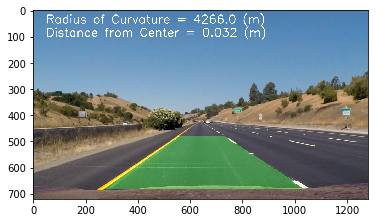

In [8]:
img = cv2.imread('./test_images/straight_lines1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_out = process_image(img)
plt.imshow(img_out)

In [9]:
clip1 = VideoFileClip('./project_video.mp4')
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!

## ONLY TO WRITE VIDEO
white_output = './output_project_video.mp4'
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video ./output_project_video.mp4
[MoviePy] Writing video ./output_project_video.mp4


100%|█████████▉| 1260/1261 [04:13<00:00,  5.20it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_project_video.mp4 

CPU times: user 4min 2s, sys: 49.6 s, total: 4min 52s
Wall time: 4min 15s


In [10]:
HTML("""
<video width="960" height="720" controls>
  <source src="{0}">
</video>
""".format(white_output))